# Chapter 4: Multi-category Classification Problem
## Lab 4: CNN-Based Multi-category Classification Model 

CIFAR-10 dataset is used to train and evaluate the performance of the multi-category classification models. For training, Categorical Cross-Entropy and Adam are utilized as the loss function and optimizer, respectively. The network models are implemented in three scenarios, which are described as follows: 
1)	Model-1: Fully connected neural network. 

2)	Model-2: Convolutional neural network.

3)	Model-3: The network architecture is exactly the same as Model-2. The image augmentation technique is applied to increase the amount and diversity of training data.


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/taipeitechmmslab/MMSLAB-DL/blob/master/Lab4.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### 1.	Preparing data 
#### a)	Import packages

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

### TensorFlow Datasets

If TensorFlow datasets is not installed, please install.

```
pip install tensorflow-datasets
```
or 

```
pip install git+https://github.com/tensorflow/datasets.git
```



#### b)	Data reading and analysis

•	View the current datasets provided by TensorFlow Datasets:

In [2]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 

•	Load CIFAR-10 dataset:

In [45]:
# Divide data into valid data and training data with a ratio of 1:9 
train_split, valid_split = ['train[:90%]', 'train[90%:]']
# Get training data 
train_data, info = tfds.load("cifar10", split=train_split, with_info=True)
# Get valid data
valid_data = tfds.load("cifar10", split=valid_split)
# Get test data
test_data = tfds.load("cifar10", split="test")

•	Display CIFAR-10 information:

In [4]:
print(info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



•	Display 10 classes of CIFAR-10:

In [5]:
labels_dict = dict(enumerate(info.features['label'].names))
labels_dict

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

•	View training data and calculate the number of each class:

In [6]:
# Create a dict to count the number of tags in each category
train_dict = {}
# # Read the entire training data set
for data in train_data:
    # Convert the read label to numpy format
    label = data['label'].numpy()
    # Count the number of each category: use a dictionary
    train_dict[label] = train_dict.setdefault(label, 0) + 1
    # train_dict.setdefault(label, 0) + 1
print(train_dict)

{7: 4500, 8: 4456, 4: 4497, 6: 4505, 5: 4503, 2: 4522, 9: 4453, 3: 4526, 0: 4530, 1: 4508}


•	Display images:

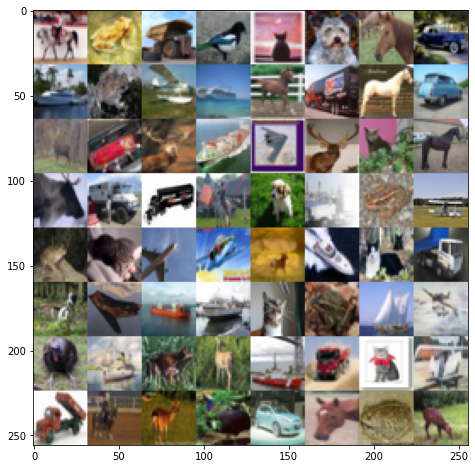

In [7]:
# Create an array to display images
output = np.zeros((32 * 8, 32 * 8, 3), dtype=np.uint8)
row = 0
# Each time 8 images, a total of 8 times, so a total of 64 images
for data in train_data.batch(8).take(8):
    # Stack the 8 images and put them in the Nth column of array
    output[:, row*32:(row+1)*32] = np.vstack(data['image'].numpy())
    row += 1
# Set the display window size
plt.figure(figsize=(8, 8))
# Display images
plt.imshow(output)

#### c)	Data division

•	Converting data:
-	Image data: standardize the input image by dividing all the pixels with 255 to scale the pixel value between 0 and 1. 
-	Label data: using One-hot encoding, for example, category 2 is represented as [0, 0, 

In [9]:
def parse_fn(dataset):
    x = tf.cast(dataset['image'], tf.float32) / 255.
    y = tf.one_hot(dataset['label'], 10)
    return x, y

•	Setting training data, validation data, and test data:

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # Automatic adjustment mode
batch_size = 64  # Batch size
train_num = int(info.splits['train'].num_examples / 10) * 9  # Number of training 

train_data = train_data.shuffle(train_num)  #Shuffle training data
# # Training data 
train_data = train_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# Set the batch size to 64 and turn on prefetch mode 
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# Validation data 
valid_data = valid_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# Set the batch size to 64 and turn on prefetch mode
valid_data = valid_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# Test data
test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# Set the batch size to 64 and turn on prefetch mode 
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

### 2.	Building and training network models

### a)	Model-1: fully connected neural network.

The architecture of Model-1:
- Input layer with shape of 32×32×3.
- Six fully connected layers, followed by ReLU activation function.
- Six dropout layers with discard rate of 30%.
- Output fully connected layer with 10 neurons, followed by Softmax activation function.


In [20]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Flatten()(inputs)
x = layers.Dense(128, activation='relu')(x)
#x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
#x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
#x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
#x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
#x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(10, activation='softmax')(x) 

#Output layer
outputs = layers.Dense(10, activation='softmax')(x) 
# Create a network model 
model_1 = keras.Model(inputs, outputs, name='model-1')
model_1.summary()  # show network architecure

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_17 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_18 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_19 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_20 (Dense)             (None, 256)               1313

•	Create a storage directory for saving model:

In [21]:
model_dir = 'lab4-logs/models'  # define directory 
os.makedirs(model_dir)  # create folder

•	Set Callback function:

In [22]:
# Save training records as TensorBoard log files 
log_dir = os.path.join('lab4-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir='lab4-logs/model-1')
# # Save the best model 
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.hdf5', 
                                             monitor='val_categorical_accuracy', 
                                             save_best_only=True, 
                                             mode='max')

•	Set the optimizer, loss function, and metric function:

In [23]:
model_1.compile(keras.optimizers.Adam(), 
               loss=keras.losses.CategoricalCrossentropy(), 
               metrics=[keras.metrics.CategoricalAccuracy()])

•	Training Model-1:

In [24]:
history_1 = model_1.fit(train_data,
                        epochs=100, 
                        validation_data=valid_data,
                        callbacks=[model_cbk, model_mckp])

Epoch 1/100
  2/704 [..............................] - ETA: 3:38 - loss: 2.3573 - categorical_accuracy: 0.0703WARNING:tensorflow:Callbacks method `on_train_batch_begin` is slow compared to the batch time (batch time: 0.0070s vs `on_train_batch_begin` time: 0.0140s). Check your callbacks.


704/704 [==============================] - 6s 8ms/step - loss: 1.9928 - categorical_accuracy: 0.2629 - val_loss: 1.8721 - val_categorical_accuracy: 0.3168
Epoch 2/100
704/704 [==============================] - 5s 7ms/step - loss: 1.8337 - categorical_accuracy: 0.3354 - val_loss: 1.7375 - val_categorical_accuracy: 0.3674
Epoch 3/100
704/704 [==============================] - 5s 7ms/step - loss: 1.7673 - categorical_accuracy: 0.3684 - val_loss: 1.7107 - val_categorical_accuracy: 0.3900
Epoch 4/100
704/704 [==============================] - 5s 7ms/step - loss: 1.7261 - categorical_accuracy: 0.3813 - val_loss: 1.6913 - val_categorical_accuracy: 0.3846
Epoch 5/100
704/704 [==============================] - 5s 7ms/step - loss: 1.6889 - categorical_accuracy: 0.3964 - val_loss: 1.6469 - val_categorical_accuracy: 0.4046
Epoch 6/100
704/704 [==============================] - 5s 7ms/step - loss: 1.6526 - categorical_accuracy: 0.4118 - val_loss: 1.5965 - val_categorical_accuracy: 0.4256
Epoch 7/10

Epoch 50/100
704/704 [==============================] - 5s 7ms/step - loss: 0.7028 - categorical_accuracy: 0.7410 - val_loss: 2.7565 - val_categorical_accuracy: 0.4384
Epoch 51/100
704/704 [==============================] - 5s 7ms/step - loss: 0.6921 - categorical_accuracy: 0.7448 - val_loss: 2.9485 - val_categorical_accuracy: 0.4354
Epoch 52/100
704/704 [==============================] - 5s 7ms/step - loss: 0.6632 - categorical_accuracy: 0.7581 - val_loss: 2.8683 - val_categorical_accuracy: 0.4364
Epoch 53/100
704/704 [==============================] - 5s 7ms/step - loss: 0.6537 - categorical_accuracy: 0.7607 - val_loss: 2.9747 - val_categorical_accuracy: 0.4414
Epoch 54/100
704/704 [==============================] - 5s 7ms/step - loss: 0.6438 - categorical_accuracy: 0.7628 - val_loss: 2.9700 - val_categorical_accuracy: 0.4388
Epoch 55/100
704/704 [==============================] - 5s 7ms/step - loss: 0.6175 - categorical_accuracy: 0.7739 - val_loss: 3.0386 - val_categorical_accuracy:

Epoch 99/100
704/704 [==============================] - 5s 7ms/step - loss: 0.3128 - categorical_accuracy: 0.8949 - val_loss: 4.6729 - val_categorical_accuracy: 0.4282
Epoch 100/100
704/704 [==============================] - 5s 7ms/step - loss: 0.2959 - categorical_accuracy: 0.9010 - val_loss: 5.1053 - val_categorical_accuracy: 0.4318


Verification on the test set:

In [26]:
loss, acc = model_1.evaluate(test_data)
print('\nModel-1 Accuracy: {}%'.format(acc))

157/157 [==============================] - 0s 2ms/step - loss: 5.0129 - categorical_accuracy: 0.4220

Model-1 Accuracy: 0.421999990940094%


### b)	Model-2: Convolutional Neural Network, without applying data augmentation for training.

The architecture of Model-1:

- Input layer with shape of 32×32×3 
- Five convolutional layers, followed by ReLU activation function.
- One max pooling layer. 
- One fully connected layer with 64 neurons, followed by ReLU activation function.
- Output fully connected layer with 10 neurons, followed by Softmax activation function. 


In [28]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)
# create model-2
model_2 = keras.Model(inputs, outputs, name='model-2')
model_2.summary()  # show network architecture

Model: "model-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 11, 11, 256)       295168    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 9, 9, 128)         295040    
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 64)          7379

•	Set Callback function:

In [16]:
# Save training records as TensorBoard log files
log_dir = os.path.join('lab4-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# Save the best model
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.hdf5', 
                                             monitor='val_categorical_accuracy', 
                                             save_best_only=True, 
                                             mode='max')

•	Set the optimizer, loss function, and metric function for training:

In [30]:
model_2.compile(keras.optimizers.Adam(), 
               loss=keras.losses.CategoricalCrossentropy(), 
               metrics=[keras.metrics.CategoricalAccuracy()])

•	Training Model-2:

In [31]:
history_2 = model_2.fit(train_data,
                        epochs=100, 
                        validation_data=valid_data,
                        callbacks=[model_cbk, model_mckp])

Epoch 1/100
  2/704 [..............................] - ETA: 5:22 - loss: 2.3122 - categorical_accuracy: 0.0859WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2649s vs `on_train_batch_end` time: 0.6452s). Check your callbacks.


704/704 [==============================] - 193s 274ms/step - loss: 1.8849 - categorical_accuracy: 0.2907 - val_loss: 1.4764 - val_categorical_accuracy: 0.4624
Epoch 2/100
704/704 [==============================] - 188s 267ms/step - loss: 1.4937 - categorical_accuracy: 0.4594 - val_loss: 1.3000 - val_categorical_accuracy: 0.5354
Epoch 3/100
704/704 [==============================] - 188s 266ms/step - loss: 1.3118 - categorical_accuracy: 0.5364 - val_loss: 1.1414 - val_categorical_accuracy: 0.5774
Epoch 4/100
704/704 [==============================] - 187s 266ms/step - loss: 1.1828 - categorical_accuracy: 0.5858 - val_loss: 1.0220 - val_categorical_accuracy: 0.6326
Epoch 5/100
704/704 [==============================] - 187s 266ms/step - loss: 1.0840 - categorical_accuracy: 0.6233 - val_loss: 0.9621 - val_categorical_accuracy: 0.6566
Epoch 6/100
704/704 [==============================] - 188s 267ms/step - loss: 1.0044 - categorical_accuracy: 0.6487 - val_loss: 0.9339 - val_categorical_acc

KeyboardInterrupt: 

Verification on the test set:

In [24]:
loss, acc = model_2.evaluate(test_data)
print('\nModel-2 Accuracy: {}%'.format(acc))

    157/Unknown - 1s 9ms/step - loss: 2.2280 - categorical_accuracy: 0.7182
Model-2 Accuracy: 0.7182000279426575%


### Image Augmentation

•	Building help functions:

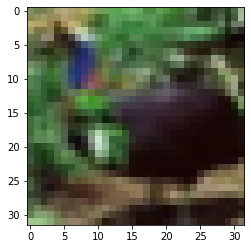

In [32]:
x = 3
y = 7
image_test = output[y*32:(y+1)*32, x*32:(x+1)*32, :]
plt.imshow(image_test)

o	Flip horizontally:

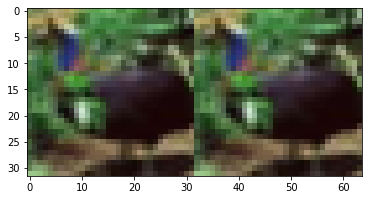

In [33]:
def flip(x):
    """
    flip image(翻轉影像)
    """
    x = tf.image.random_flip_left_right(x)  # 隨機左右翻轉影像
    return x

image_2 = flip(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

o	Color Conversion:

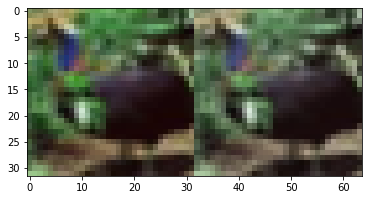

In [35]:
def color(x):
    """
     Color change(改變顏色)
    """
    x = tf.image.random_hue(x, 0.08)  # Adjust the hue of image by a random factor
    x = tf.image.random_saturation(x, 0.6, 1.6)  # Randomly adjust image saturation
    x = tf.image.random_brightness(x, 0.05)  # Randomly adjust image brightness
    x = tf.image.random_contrast(x, 0.7, 1.3)  # Randomly adjust image contrast
    return x


image_2 = color(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

o	Image rotation:

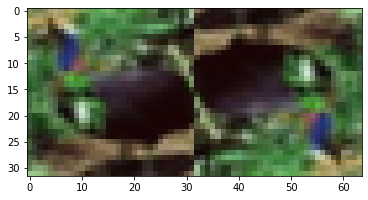

In [36]:
def rotate(x):
    """
    Rotation image
    """
    # Randomly select n times (set the range of n through minval and maxval), 
    x = tf.image.rot90(x, tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32))
    return x

image_2 = rotate(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

o	Zoom image:

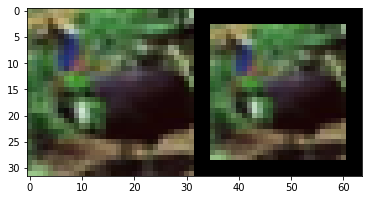

In [37]:
def zoom(x, scale_min=0.6, scale_max=1.4):
    """
    Zoom Image(影像縮放)
    """
    h, w, c = x.shape
    scale = tf.random.uniform([], scale_min, scale_max)  # Random scaling
    sh = h * scale  # the height of image after zooming 
    sw = w * scale  # the width of image after zooming
    x = tf.image.resize(x, (sh, sw))  # resize
    x = tf.image.resize_with_crop_or_pad(x, h, w)  # Image cropping and filling
    return x

image_2 = zoom(image_test)
# Horizontally merge the images before and after processing
image_2 = tf.cast(image_2, dtype=tf.uint8)
image = np.hstack((image_test, image_2)) 
# Display
plt.imshow(image)


### Setting data for training (Dataset with augmentation)

o	Reload Dataset: Because the dataset has been set before, it is necessary to reload:

In [38]:
train_data = tfds.load("cifar10", split=train_split)

Data Prepossessing:
-	Normalization: divide all pixels in the image by 255 to scale the pixel value between 0 and1.
-	Image augmentation: flip image horizontally, rotate image, convert colors, and zoom image.
-	Label data: using One-hot encoding, for example, category 2 is represented as [0, 0, 0, 0, 0, 0, 0, 0, 1, 0].

In [39]:
def parse_aug_fn(dataset):
    """
    Image Augmentation function
    """
    x = tf.cast(dataset['image'], tf.float32) / 255.  #  Image standardization
    x = flip(x)  # Random horizontal flip
    # # color conversion
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: color(x), lambda: x)
    # image rotation
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: rotate(x), lambda: x)
    # image zoom
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: zoom(x), lambda: x)
    # Convert the output label to One-hot encoding
    y = tf.one_hot(dataset['label'], 10)
    return x, y

o	Training data after performing image augmentation:

In [40]:
# shuffle data
train_data = train_data.shuffle(train_num)
# Loading data
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
# Set batch size and turn on prefetch mode
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

o	Displaying data after performing image augmentation:

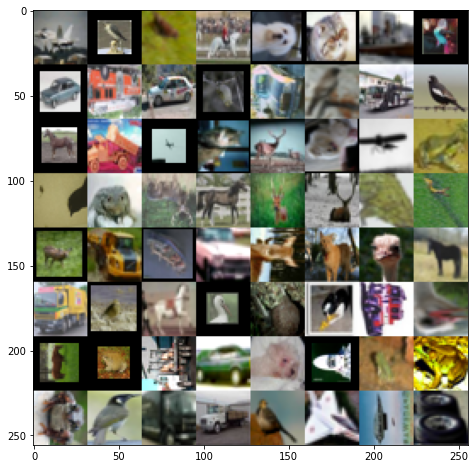

In [41]:
for images, labels in train_data.take(1):
    images = images.numpy()
# Create an array to display images
output = np.zeros((32 * 8, 32 * 8, 3))
# add 64 data into the array for displaying images
for i in range(8):
    for j in range(8):
        output[i*32:(i+1)*32, j*32:(j+1)*32, :] = images[i*8+j]
plt.figure(figsize=(8, 8))
# Display image
plt.imshow(output)

### c)	Model-3: Convolutional neural network, apply data augmentation for training.

The architecture of Model-3: 
- Input layer with shape of 32×32×3 
- Five convolutional layers, followed by ReLU activation function.
- One max pooling layer 
- One fully connected layer with 64 neurons, followed by ReLU activation function.
- Output fully connected layer with 10 neurons, followed by Softmax activation function. 


In [42]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)
# create model-3
model_3 = keras.Model(inputs, outputs, name='model-3')
model_3.summary()  # show architecture

Model: "model-3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 11, 11, 256)       295168    
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 9, 9, 128)         295040    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 7, 7, 64)          7379

•	Set Callback function:

In [28]:
# Save training records as TensorBoard log files
log_dir = os.path.join('lab4-logs', 'model-3')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# Save the best model
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-3.hdf5', 
                                             monitor='val_categorical_accuracy', 
                                             save_best_only=True, 
                                             mode='max')

•	Set the optimizer, loss function, and metric function for training:

In [43]:
model_3.compile(keras.optimizers.Adam(), 
               loss=keras.losses.CategoricalCrossentropy(), 
               metrics=[keras.metrics.CategoricalAccuracy()])

•	Training Model-3:

In [44]:
history_3 = model_3.fit(train_data,
                        epochs=100, 
                        validation_data=valid_data,
                        callbacks=[model_cbk, model_mckp])

Epoch 1/100
  2/704 [..............................] - ETA: 5:34 - loss: 2.3066 - categorical_accuracy: 0.1016WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2619s vs `on_train_batch_end` time: 0.6806s). Check your callbacks.


704/704 [==============================] - 196s 279ms/step - loss: 2.0316 - categorical_accuracy: 0.2329 - val_loss: 1.6508 - val_categorical_accuracy: 0.3806
Epoch 2/100
704/704 [==============================] - 196s 278ms/step - loss: 1.8124 - categorical_accuracy: 0.3338 - val_loss: 1.4761 - val_categorical_accuracy: 0.4488
Epoch 3/100
704/704 [==============================] - 199s 283ms/step - loss: 1.6811 - categorical_accuracy: 0.3904 - val_loss: 1.3907 - val_categorical_accuracy: 0.5034
Epoch 4/100
704/704 [==============================] - 198s 281ms/step - loss: 1.6068 - categorical_accuracy: 0.4202 - val_loss: 1.2881 - val_categorical_accuracy: 0.5394
Epoch 5/100
704/704 [==============================] - 190s 270ms/step - loss: 1.5270 - categorical_accuracy: 0.4506 - val_loss: 1.2224 - val_categorical_accuracy: 0.5616
Epoch 6/100
704/704 [==============================] - 199s 282ms/step - loss: 1.4661 - categorical_accuracy: 0.4786 - val_loss: 1.1257 - val_categorical_acc

KeyboardInterrupt: 

Verification on the test set:

In [43]:
loss, acc = model_3.evaluate(test_data)
print('\nModel-3 Accuracy: {}%'.format(acc))

    157/Unknown - 2s 10ms/step - loss: 0.6237 - categorical_accuracy: 0.7999
Model-3 Accuracy: 0.7998999953269958%


### 3.	Displaying results

•	Load model weights:

In [44]:
model_1.load_weights('lab4-logs/models/Best-model-1.hdf5')
model_2.load_weights('lab4-logs/models/Best-model-2.hdf5')
model_3.load_weights('lab4-logs/models/Best-model-3.hdf5')
loss_1, acc_1 = model_1.evaluate(test_data)
loss_2, acc_2 = model_2.evaluate(test_data)
loss_3, acc_3 = model_3.evaluate(test_data)

    157/Unknown - 1s 9ms/step - loss: 0.6311 - categorical_accuracy: 0.7980

•	Verification on the test data:

In [44]:
loss_1, acc_1 = model_1.evaluate(test_data)
loss_2, acc_2 = model_2.evaluate(test_data)
loss_3, acc_3 = model_3.evaluate(test_data)

    157/Unknown - 1s 9ms/step - loss: 0.6311 - categorical_accuracy: 0.7980

•	Display the loss value and accuracy result:

In [45]:
loss = [loss_1, loss_2, loss_3]  
acc = [acc_1, acc_2, acc_3]

dict = {"Loss": loss,  
        "Accuracy": acc}

df = pd.DataFrame(dict)
df

,Loss,Accuracy
0,1.662437,0.4453
1,2.209503,0.7211
2,0.631140,0.7980
